In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

2024-05-22 01:01:32.514264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data import as for the classification model:

In [2]:
from sklearn.model_selection import train_test_split

# Loading the training data
train_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Loading the test data
# test_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/test_set.csv', index_col="Id")
# test_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
# test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
# print("The test set contains {} examples.".format(len(test_df)))

#take first 20 columns the values of 0 and 1 of the dataframe as labels
labels_df = train_df.iloc[:, :20]
train_labels = labels_df.values

# Define a function to resize images
def resize_images(img_series, size=(224, 224)):
    return img_series.apply(lambda img: cv2.resize(img, size))

# Resize and convert the images to a numpy array
train_images = np.stack(resize_images(train_df["img"]).values)
#test_images = np.stack(resize_images(test_df["img"]).values)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)

# Normalization
print(np.max(X_train))
X_train = X_train / 255
X_val  = X_val / 255
print(np.max(X_train))

The training set contains 749 examples.
255
1.0


Re-importing the best model trained for classification, the one on which we'll plan the adversarial attack on:

In [3]:
from keras.applications import InceptionResNetV2
from tensorflow.keras import regularizers

base_model = InceptionResNetV2(include_top=False,
                                      weights="imagenet",     # "imagenet" when transfer learning
                                      input_shape=(224, 224, 3),
                                      pooling = "avg"
                                      )
x = base_model.output
x = Dropout(0.2)(x)
x = Dense(512, activation="relu", kernel_regularizer=regularizers.L2(0.001))(x)
x = Dense(512, activation="relu", kernel_regularizer=regularizers.L2(0.001))(x)

predictions = Dense(20, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.load_weights("/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/InceptionResNetV2_noweights_best.h5")

2024-05-22 01:02:27.856933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The adversarial attack has been implemented following a tutorial by Eric Muccino on Medium.com. The idea is to create a model that is identical to our best trained classification models with an additional adversarial block. This block will create adversarial noise which when added to the input data will confuse the classification model. 

In practice, the block is composed of an adversarial layer which is a dense layer of as many neurons as pixel in the input images fully connected to a single neuron of constant value 1 (Unity layer). This means that each neuron of this adversarial layer represents the weight that will be applied to each single pixel. The outputs of the adversarial layer, called the adversarial noises, are reschaped and then added to the input images in such a way that the input images visually look unchanged but that will impact the classification task.

The training works using the categorical cross entropy loss function, to which we give the "false" class that we want to attribuate. We have trained our adversarial model on cat pictures with the target classification being bird. Of course, only the new layers of the model were trained. All layers from our initial model were frozen. Additionally, regularization, we have picked l1, has been applied to keep the pixel pertubation small (and so unseen).

Here is a summary of the model:
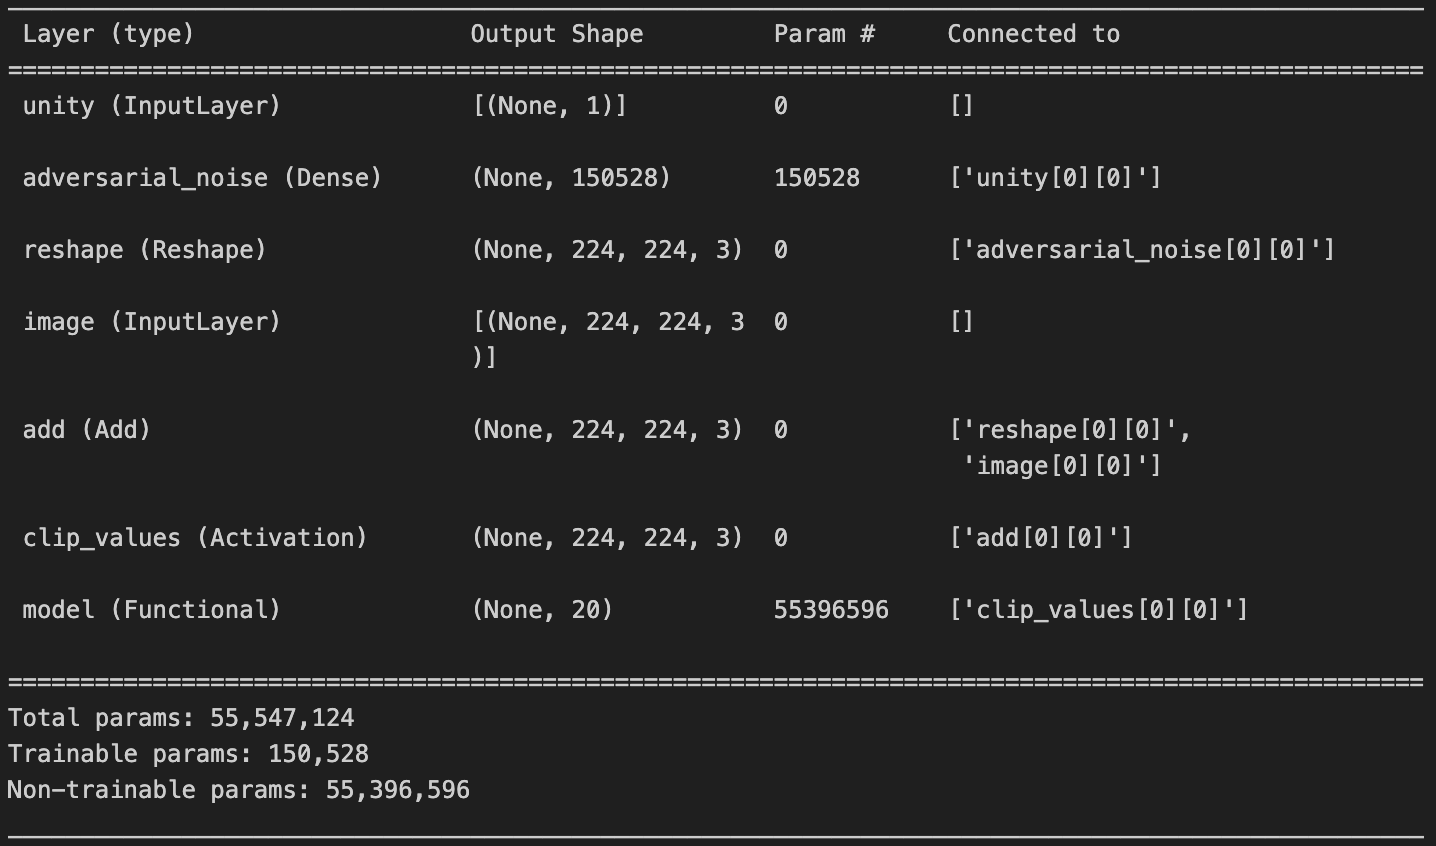

### Adversarial Attack of a single image
Below is the first test version where the adversarial attack model is trained on a single image manually provided, creating the corresponding adversarial perturbation and image.

In [6]:
im_size = 224
im_depth = 3

# Function to force pixel values between 0 and 1
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add this function to dictionary
get_custom_objects().update({'clip': Activation(clip)})

# Training a model to create an adversarial pertubation for a batch of images
def train_adversary_model_one_image(one_image, target_class, model, regularization, loss_function, epochs=100):
    image = Input(shape=(im_size, im_size, im_depth),name='image')
    one = Input(shape=(1,),name='unity')

    # Adversarial layer
    noise = Dense(im_size * im_size * im_depth, activation = None, use_bias=False, kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)

    noise = Reshape((im_size, im_size, im_depth), name='reshape')(noise)
    
    # Add noise to images & Clip pixels to [0,1]
    net = Add(name='add')([noise,image])
    net = Activation('clip',name='clip_values')(net)
    
    # Feed adversarial images to our (best) trained classifier
    outputs = model(net)

    # Adversarial model
    adversarial_model = Model(inputs=[image,one], outputs=outputs)

    # Freeze layers of our trained classifier
    adversarial_model.layers[-1].trainable = False
    
    # Compile adversarial model (with SGD optimizer and categorical accuracy for the metric)
    adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=[categorical_accuracy])

    # Target adversarial classification
    target_vector = np.zeros(20)
    target_vector[target_class] = 1.
    
    # Callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('/Users/perrinebamps/Documents/adversarial_weights_oneimage.h5', monitor='loss', verbose=0, 
                                 save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    
    # Train adversarial image
    adversarial_model.fit(x={'image': np.expand_dims(one_image, axis=0), 'unity': np.ones(shape=(1, 1))}, y=target_vector.reshape(1,-1), epochs=epochs, verbose=0,
                         callbacks=[checkpoint])
    
    # Restore best weights
    adversarial_model.load_weights('/Users/perrinebamps/Documents/adversarial_weights_oneimage.h5')
    
    # Quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((im_size, im_size, im_depth)) * 255.) / 255.
 
    #add trained weights to original image and clip values to produce adversarial image
    adv_image = np.clip(one_image.reshape((im_size, im_size, im_depth)) + quantized_weights, 0., 1.)
    
    #print(adversarial_model.summary())
    
    return adv_image, quantized_weights


Attacked class is Cat (position 7 in class labels) and predicting it as Bird (position 2 in class labels):

In [7]:
def model_predictions(image):
    predictions = model.predict(image.reshape((1, im_size, im_size, im_depth)))
    return predictions

def attacked_model_predictions(image):
    # Classify the image per the best classification model
    predictions = model_predictions(image)

    # Check if the image is classified as Cat (i.e. chosen attacked class)
    if predictions.argmax() == 7:
        # Generate adversarial perturbation targeting Bird class
        adv_img, adv_weights = train_adversary_model_one_image(image, 2, model, l1(0.01), 'categorical_crossentropy')
        
        # Re-classify the adversarial image per the best classification model
        predictions = model_predictions(adv_img)

        return predictions, adv_img, adv_weights
    
    else:
        return predictions, image, np.zeros((im_size, im_size, im_depth))

Example for an image of the class attacked:

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1/1 [==============================] - 9s 9s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 unity (InputLayer)             [(None, 1)]          0           []                               
              

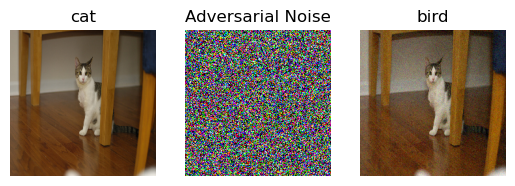

In [8]:
# True image and class label from training set
img_true = X_train[3]
ind_true = y_train[3].argmax()

# Attacked image and predicted class label
predictions, img_adv, noise_adv = attacked_model_predictions(img_true)
ind_adv = predictions.argmax()

# Plots
fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(np.clip(noise_adv*100, 0, 1))   # (Noise * 100) to amplify it and improve visibility on plot
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')

axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()


Example for an image of another class:

1/1 [==============================] - 1s 574ms/step


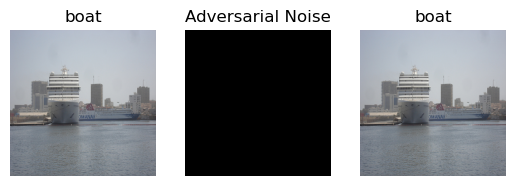

In [9]:
# True image and class label from training set
img_true = X_train[2]
ind_true = y_train[2].argmax()

# Attacked image and predicted class label
predictions, img_adv, noise_adv = attacked_model_predictions(img_true)
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(np.clip(noise_adv*100, 0, 1))  
     # (Noise * 100) to amplify it and improve visibility & clip to color range.
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')

axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()

### Adversarial Attack Model (trained individually for each image)
Then, we have slightly updated the code so the model would be trained in advance for all images of cat. In this first version, the model is trained individually for each image, resulting in a distinct adversarial perturbation for each image.

In [11]:
im_size = 224
im_depth = 3

# Function to force pixel values between 0 and 1
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add this function to dictionary
get_custom_objects().update({'clip': Activation(clip)})

# Training a model to create an adversarial pertubation for a batch of images
def train_adversary_model_for_each_image(batch_images, target_class, model, regularization, loss_function, epochs=100):
    adversarial_noises = []

    for i, img in enumerate(batch_images):
        image = Input(shape=(im_size, im_size, im_depth), name='image')
        one = Input(shape=(1,), name='unity')

        # Adversarial layer
        noise = Dense(im_size * im_size * im_depth, activation=None, use_bias=False, kernel_initializer='random_normal',
                      kernel_regularizer=regularization, name='adversarial_noise')(one)

        noise = Reshape((im_size, im_size, im_depth), name='reshape')(noise)

        # Add noise to images & Clip pixels to [0,1]
        net = Add(name='add')([noise, image])
        net = Activation('clip', name='clip_values')(net)

        # Feed adversarial images to our (best) trained classifier
        outputs = model(net)

        # Adversarial model
        adversarial_model = Model(inputs=[image, one], outputs=outputs)
        
        # Freeze layers of our trained classifier
        adversarial_model.layers[-1].trainable = False

        # Compile adversarial model (with SGD optimizer and categorical accuracy for the metric)
        adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=['categorical_accuracy'])

        # Target adversarial classification
        target_vector = np.zeros((1, 20))
        target_vector[:, target] = 1.

        # Callback for saving weights with smallest loss
        checkpoint = ModelCheckpoint(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_weights_{i}.h5', monitor='loss', verbose=0, 
                                    save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

        # Expand dimensions of image to include batch size of 1
        array_batch = np.expand_dims(img, axis=0)
        one_batch = np.ones((1, 1))

        # Train adversarial image
        adversarial_model.fit(x={'image': array_batch, 'unity': one_batch}, y=target_vector, epochs=epochs, verbose=0,
                             callbacks=[checkpoint])

        # Restore best weights
        adversarial_model.load_weights(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_weights_{i}.h5')

        # Quantize adversarial noise
        quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((im_size, im_size, im_depth)) * 255.) / 255.

        # Save adversarial noise weights
        adversarial_noises.append(quantized_weights)
        np.save(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_noise_{i}.npy', quantized_weights)

    np.save(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_noises.npy', adversarial_noises)
    return adversarial_noises


In [12]:
# Subselect all images of Cats & Force classification to be Bird:
batch_images = X_train[np.argmax(y_train, axis=1)==7]   # 7 = Cat
target = 2

# Train the adversarial model with l1 regularization and categorical crossentropy loss as the loss function
adversarial_noises = train_adversary_model_for_each_image(batch_images, target, model, l1(0.01), 'categorical_crossentropy')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [ ]:
# Reload pre-trained weights
adversarial_noises=[]
for i in range(39):
    adversarial_noises.append(np.load(f'/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/weights/adversarial_noise_{i}.npy'))

In [16]:
def attacked_model_predictions_by_image(image, model, adversarial_noise):
    # Apply pre-trained adversarial noise to original image
    adversarial_img = np.clip(image + adversarial_noise, 0., 1.)
        
    # Re-classify the adversarial image with our trained model
    predictions = model.predict(np.expand_dims(adversarial_img, axis=0))
    
    return predictions, adversarial_img

1/1 [==============================] - 0s 458ms/step


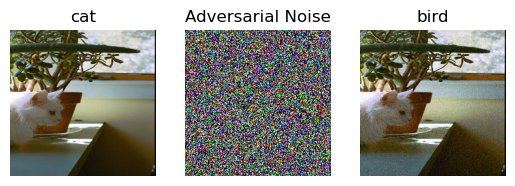

In [17]:
# Test with one image of cat:
i = 25
img = X_train[np.argmax(y_train, axis=1)==7][i]
predictions, adv_img = attacked_model_predictions_by_image(img, model, adversarial_noises[i])

ind_true = 7
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(clip(adversarial_noises[1]*100))
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')

axs[2].imshow(adv_img)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()


1/1 [==============================] - 0s 390ms/step


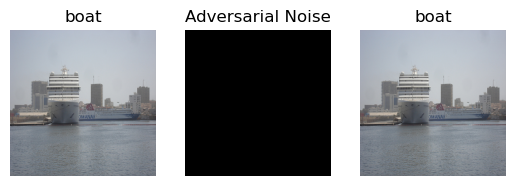

In [22]:
# Test with an image of another class:
c = 3
i = 0
img = X_train[np.argmax(y_train, axis=1)==c][i]
adv_noise=np.zeros_like(img)
predictions, adv_img = attacked_model_predictions_by_image(img, model, adv_noise)

ind_true = c
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(clip(adv_noise))
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')

axs[2].imshow(adv_img)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()

### Aversarial Attack Model (trained at once for all images)
Again, we slightly adapted the code to make a new version where the adversarial model is trained with all images of the attacked class at once, creating then one adversarial perturbation that works for all images.

In [179]:
im_size = 224
im_depth = 3

# Function to force pixel values between 0 and 1
def clip(x):
    return K.clip(x, 0.0, 1.0)

# Add this function to dictionary
get_custom_objects().update({'clip': Activation(clip)})

# Training a model to create an adversarial pertubation for a batch of images
def train_adversary_model_for_batch(batch_images, target_class, model, regularization, loss_function, epochs=100):
    image = Input(shape=(im_size, im_size, im_depth), name='image')
    one = Input(shape=(1,), name='unity')
    
    # Adversarial layer
    noise = Dense(im_size * im_size * im_depth, activation=None, use_bias=False, kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    noise = Reshape((im_size, im_size, im_depth), name='reshape')(noise)
    
    # Add noise to images & Clip pixels to [0,1]
    net = Add(name='add')([noise, image])
    net = Activation('clip', name='clip_values')(net)
    
    # Feed adversarial images to our (best) trained classifier
    outputs = model(net)

    # Adversarial model
    adversarial_model = Model(inputs=[image, one], outputs=outputs)
    
    # Freeze layers of our trained classifier
    adversarial_model.layers[-1].trainable = False
    
    # Compile adversarial model (with SGD optimizer and categorical accuracy for the metric)
    adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=[categorical_accuracy])
        
    # Target adversarial classification
    target_vector = np.zeros((len(batch_images), 20))
    target_vector[:, target_class] = 1.
    
    # Callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/adversarial_weights.h5', monitor='loss', verbose=0, 
                                 save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    
    # Expand dimensions of images to include batch size
    array_batch = np.array(batch_images)
    one_batch = np.ones((len(batch_images), 1))
    
    # Train adversarial model
    adversarial_model.fit(x={'image': array_batch, 'unity': one_batch}, y=target_vector, epochs=epochs, verbose=0,
                         callbacks=[checkpoint])
    
    # Restore best weights
    adversarial_model.load_weights('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/adversarial_weights.h5')
    
    # Quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((im_size, im_size, im_depth)) * 255.) / 255.
    
    # Save adversarial noise weights
    np.save('/Users/perrinebamps/Documents/MAI2023-2024/ProjectCV/generalized_adversarial_noise.npy', quantized_weights)
    
    return quantized_weights

# Subselect all images of Cats & Force classification to be Bird:
batch_images = X_train[np.argmax(y_train, axis=1)==7]   # 7 = Cat
target = 2  # 2 = Bird
# Train the adversarial model with l1 regularization and categorical crossentropy loss as the loss function
adversarial_noise = train_adversary_model_for_batch(batch_images, target, model, l1(0.01), 'categorical_crossentropy', epochs=100)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


1/1 [==============================] - 0s 395ms/step


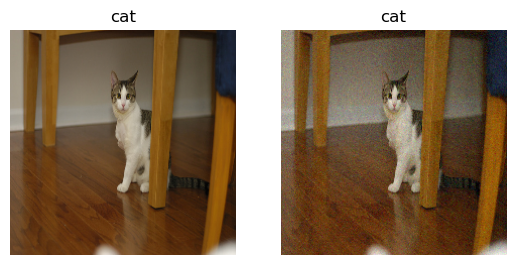

In [193]:
def attacked_model_predictions_by_batch(image, model, adversarial_noise):
    # Apply pre-trained adversarial noise to original image
    adversarial_img = np.clip(image + adversarial_noise, 0., 1.)
        
    # Re-classify the adversarial image with our trained model
    predictions = model.predict(np.expand_dims(adversarial_img, axis=0))
    
    return predictions, adversarial_img

# Test with one image of cat:
img = X_train[np.argmax(y_train, axis=1)==7][0,:,:,:]
predictions, adv_img = attacked_model_predictions_by_batch(img, model, adversarial_noise)

ind_true = 7
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')

axs[1].imshow(adv_img)
axs[1].set_title(labels_df.columns.tolist()[ind_adv])
axs[1].axis('off')
plt.show()